In [1]:
import pandas as pd
import numpy as np
import ast
import random
import os

In [2]:
#load go term data as go_terms, remove 3 broad go terms
#source: http://geneontology.org/docs/download-go-annotations/

go_terms = pd.read_csv('/Users/clairedubin/spur/publishable_data/external_datasets/go_terms.csv', header=None)
go_terms = go_terms.drop(columns=[0, 1,3,5,6,7,8,11,12,13,14,15])
go_terms = go_terms.rename(columns={2: 'sgd_name', 4:'go_term', 9:'gene_desc', 10:'gene'})
go_terms['gene'] = [i[0] for i in go_terms['gene'].str.split('|')]
go_terms = go_terms.drop_duplicates()
go_terms = go_terms[~go_terms['go_term'].isin(['GO:0005575', 'GO:0008150', 'GO:0003674'])]
go_terms = go_terms.set_index('gene')
go_terms.head()

,sgd_name,go_term,gene_desc
gene,,,
YDL159W,STE7,GO:0000187,Signal transducing MAP kinase kinase
YJL128C,PBS2,GO:0000187,MAP kinase kinase of the HOG signaling pathway
YOL144W,NOP8,GO:0003723,Nucleolar protein required for 60S ribosomal s...
YIL095W,PRK1,GO:0120133,Ser/Thr protein kinase
YER038W-A,FMP49,GO:0005739,Mitochondrial protein of unknown function


In [3]:
#load list of essential genes as essential_genes
#source: http://www-sequence.stanford.edu/group/yeast_deletion_project/Essential_ORFs.txt

essential = pd.read_csv('/Users/clairedubin/spur/publishable_data/external_datasets/essential.csv', header=None)
essential[1] = essential[1].str.strip('\t')
essential_genes = essential[1].str.strip(' ').tolist()

In [18]:
df = pd.read_csv('/Users/clairedubin/spur/publishable_data/raw_data/dxy_SpC_vineyard_011420.csv')
df['gene'] = df['Unnamed: 0'].str.split('_', expand=True)[2]
df=df.drop(columns=['Unnamed: 0'])
df.head()

,dxy,gene
0,0.143707,YNL302C
1,0.134195,YBR070C
2,0.083513,YIL093C
3,0.146755,YKR078W
4,0.126110,YKR086W


In [19]:
merged = df.merge(go_terms, right_index=True, left_on='gene')
merged.head()

,dxy,gene,sgd_name,go_term,gene_desc
0,0.143707,YNL302C,RPS19B,GO:0003735,Protein component of the small (40S) ribosomal...
0,0.143707,YNL302C,RPS19B,GO:0002181,Protein component of the small (40S) ribosomal...
0,0.143707,YNL302C,RPS19B,GO:0006407,Protein component of the small (40S) ribosomal...
0,0.143707,YNL302C,RPS19B,GO:0042274,Protein component of the small (40S) ribosomal...
0,0.143707,YNL302C,RPS19B,GO:0022627,Protein component of the small (40S) ribosomal...


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


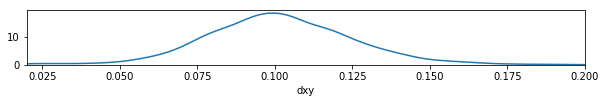

In [20]:
import matplotlib.pyplot as plt

graph = merged.drop_duplicates('gene')['dxy'].dropna()

import seaborn as sns, numpy as np

fig = plt.figure(figsize=(10, 1))
ax = sns.distplot(graph, hist=False)
plt.xlim(0.02, 0.2)


# ax.set_label(r'$D_{xy}$',fontname="Microsoft Sans Serif", fontsize=20, rotation="horizontal", labelpad=-32,  y=1.08)
# cb1.ax.tick_params(labelsize=14)
# cb1.ax.yaxis.set_ticks_position('right')

# fig.savefig('dxy_colorbar.png', dpi=2000)
fig.savefig("./{}.eps".format('dxy_wine_colorbar.png'),  dpi=1000,)

In [21]:
def resample(go_term, gene_list, r1, r2):
    
        loc = go_term_groups_75.loc[go_term]
#         gene_list = ast.literal_eval(loc['tested_gene_list'])
        essential_count = int(loc['tested_essential_count'])
        non_essential_count = int(loc['tested_gene_counts'] - essential_count)

        my_dxy_median = loc['dxy_median']
        print(my_dxy_median)

        sample_dxy_med = 0

        for i in range(10000):

            sample = essential_df.sample(n=essential_count,replace=True, random_state=r1)
            sample = sample.append(non_essential_df.sample(n=non_essential_count,replace=True, random_state=r2))

            if sample['dxy'].median() >= my_dxy_median:
                sample_dxy_med += 1


        rv = sample_dxy_med/10000
        print(go_term, rv)
        return rv

In [22]:
go5778_genes = merged[merged['go_term']=='GO:0005778']['dxy'].median()
go5778_genes

0.11597189698150216

In [ ]:
results = {}

r1 = np.random.seed(521)
r2 = np.random.seed(428)

temp = merged.copy()

temp['essential'] = temp['gene'].isin(essential_genes)

#split merged data into essential and nonessential genes
unique_merged = temp.drop(columns=['go_term']).drop_duplicates()
essential_df = unique_merged[unique_merged['gene'].isin(essential_genes)]
non_essential_df = unique_merged[~unique_merged['gene'].isin(essential_genes)]

#group by GO term, add columns with count of genes in each GO term tested in population tests and total amount of genes in GO term
go_term_groups = temp.groupby('go_term').count()['dxy'].to_frame().rename(columns={'dxy':'tested_gene_counts'})
total_counts = temp.groupby('go_term').count()['gene']
essential_counts = temp.groupby('go_term').sum()['essential']

go_term_groups['total_gene_counts'] = total_counts
go_term_groups['tested_essential_count'] = essential_counts

medians = temp.groupby('go_term').median()[['dxy']].add_suffix('_median')

go_term_groups = go_term_groups.merge(medians, right_index=True, left_index=True)

go_term_groups = go_term_groups[['dxy_median', 'tested_gene_counts', 'total_gene_counts', 'tested_essential_count']]

#eliminate GO terms with less than 75% of genes used in MK test or less than 10 genes tested
go_term_groups_75 = go_term_groups[go_term_groups['tested_gene_counts']/go_term_groups['total_gene_counts'] > .75]
go_term_groups_75 = go_term_groups_75[go_term_groups_75['tested_gene_counts'] > 10]

results[pop] = resample('GO:0005778', go5778_genes, r1, r2)

go_term_groups


0.11377589584586667


In [ ]:
go_term_groups.to_csv('/Users/clairedubin/spur/publishable_data/raw_data/population_dxy_resampling_110619.csv')


In [71]:
#euro wine without PEX18 and PEX27
go5778_minus1827 = df[(df['gene'].isin(go5778_genes)) &(df['population'] == '1WineEuropean') &
   (~df['gene'].isin(['YHR160C', 'YOR193W']))]

essential_count = go5778_minus1827[go5778_minus1827['gene'].isin(essential_genes)].shape[0]
non_essential_count = int(go5778_minus1827.shape[0] - essential_count)

temp = merged[merged['population'] == '1WineEuropean']
temp['essential'] = temp['gene'].isin(essential_genes)

#split merged data into essential and nonessential genes
unique_merged = temp.drop(columns=['go_term']).drop_duplicates()
essential_df = unique_merged[unique_merged['gene'].isin(essential_genes)]
non_essential_df = unique_merged[~unique_merged['gene'].isin(essential_genes)]

#group by GO term, add columns with count of genes in each GO term tested in population tests and total amount of genes in GO term
go_term_groups = temp.groupby('go_term').count()['dxy'].to_frame().rename(columns={'dxy':'tested_gene_counts'})
total_counts = temp.groupby('go_term').count()['gene']
essential_counts = temp.groupby('go_term').sum()['essential']

go_term_groups['total_gene_counts'] = total_counts
go_term_groups['tested_essential_count'] = essential_counts

medians = temp.groupby('go_term').median()[['dxy']].add_suffix('_median')

go_term_groups = go_term_groups.merge(medians, right_index=True, left_index=True)

go_term_groups = go_term_groups[['dxy_median', 'tested_gene_counts', 'total_gene_counts', 'tested_essential_count']]

#eliminate GO terms with less than 75% of genes used in MK test or less than 10 genes tested
go_term_groups_75 = go_term_groups[go_term_groups['tested_gene_counts']/go_term_groups['total_gene_counts'] > .75]
go_term_groups_75 = go_term_groups_75[go_term_groups_75['tested_gene_counts'] > 10]

r1 = np.random.seed(5)
r2 = np.random.seed(6)


my_dxy_median = go5778_minus1827['dxy'].median()
print(my_dxy_median)

sample_dxy_med = 0

for i in range(10000):

    sample = essential_df.sample(n=essential_count,replace=True, random_state=r1)
    sample = sample.append(non_essential_df.sample(n=non_essential_count,replace=True, random_state=r2))

    if sample['dxy'].median() >= my_dxy_median:
        sample_dxy_med += 1


print('Dxy p for GO:0005778 without PEX18 and PEX27: ', sample_dxy_med/10000)



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0.10888385011122634
Dxy p for GO:0005778 without PEX18 and PEX27:  0.0227


In [42]:
go_term_groups_75.loc['GO:0005778']

dxy_median                 0.110488
tested_gene_counts        32.000000
total_gene_counts         32.000000
tested_essential_count     1.000000
Name: GO:0005778, dtype: float64

In [55]:
results_df = pd.DataFrame.from_dict(results,orient='index')
results_df.columns = ['dxy_p']
results_df.to_csv('/Users/clairedubin/spur/publishable_data/raw_data/scer_population_dxy_resampling_pvals_102319.csv')

In [56]:
results_df.to_clipboard(sep='\t')